In [ ]:
pip install pandas tqdm matplotlib seaborn

In [ ]:
"""
This script analyzes insider trading data with forward returns, focusing on the impact of transaction type, insider title, and trade size.

Main Steps:
1. Imports required libraries (pandas, matplotlib).
2. Loads and cleans the insider trades dataset, ensuring numeric columns are properly formatted.
3. Calculates average and median forward returns grouped by transaction type (purchase/sale).
4. Visualizes mean and median forward returns over different time horizons.
5. Groups insiders by title, maps titles to standardized categories, and analyzes performance by title group.
6. Examines the effect of trade size by dividing trades into quartiles and computing average returns for each group.
7. Plots distributions and trends using matplotlib and seaborn.
8. Loads ticker price histories and overlays insider trades on price charts for selected tickers.
9. Identifies clusters of multiple insiders trading on the same day or week for further analysis.

Variables:
- df: Main DataFrame containing insider trades and forward returns.
- avg_returns, median_returns: DataFrames of mean/median returns by transaction type.
- avg_by_title: Median forward returns grouped by standardized insider titles.
- avg_by_size: Mean forward returns grouped by transaction type and trade size quartile.
- fwd_cols: List of forward return columns.
- title_counts, common_groups: Frequency counts of insider titles.
- clusters: DataFrames identifying clusters of insider trades by day/week.
- get_ticker_price_history: Function to load and clean price history for a given ticker.

Usage:
- Run each cell sequentially to load data, perform analysis, and generate plots.
- Adjust file paths and parameters as needed for your dataset.
- Use the provided functions and grouped results to explore patterns in insider trading and subsequent stock performance.
"""

In [122]:
import pandas as pd

pd.set_option('display.width', 200)
df = pd.read_csv("insider_trades_with_returns.csv")
df = df.dropna(subset=["fwd_1d", "fwd_5d", "fwd_15d"])

fwd_cols = ['fwd_1d', 'fwd_5d', 'fwd_15d', 'fwd_30d', 'fwd_60d', 'fwd_90d', 'fwd_180d']
for col in fwd_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Clean purchase_price & Value to numeric
df["purchase_price"] = df["purchase_price"].replace('[\$,]', '', regex=True).astype(float)
df["Value"] = df["Value"].replace('[\$,]', '', regex=True).astype(float)

df['Title_clean'] = df['Title'].str.lower().str.strip()  # Lowercase and strip

Average Forward Returns by Transaction Type:
                    fwd_1d     fwd_5d    fwd_15d    fwd_30d    fwd_60d    fwd_90d   fwd_180d
transaction_type                                                                            
P - Purchase      0.943281  27.303229  27.541020  26.851629  24.667495  47.480782  57.240741
S - Sale          9.354531   7.005957   8.957417  10.003221   8.553670   6.089918   8.029613


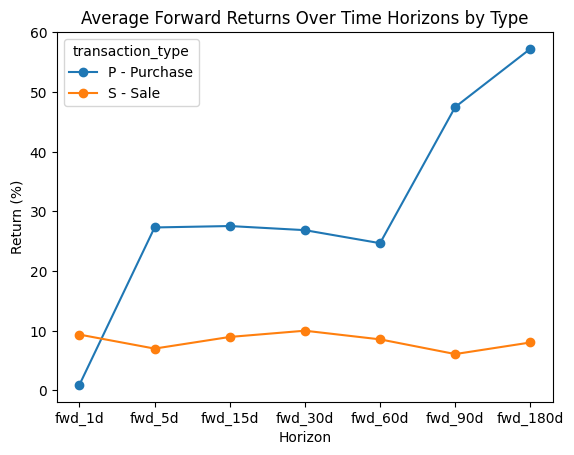

Median Forward Returns by Transaction Type:
                    fwd_1d    fwd_5d   fwd_15d   fwd_30d   fwd_60d   fwd_90d  fwd_180d
transaction_type                                                                      
P - Purchase      0.337846  1.298706  1.791944  1.989362  3.091151  2.554745  3.100783
S - Sale          0.025613  0.000000  0.409458  0.543181  1.396912  1.683017  4.396339


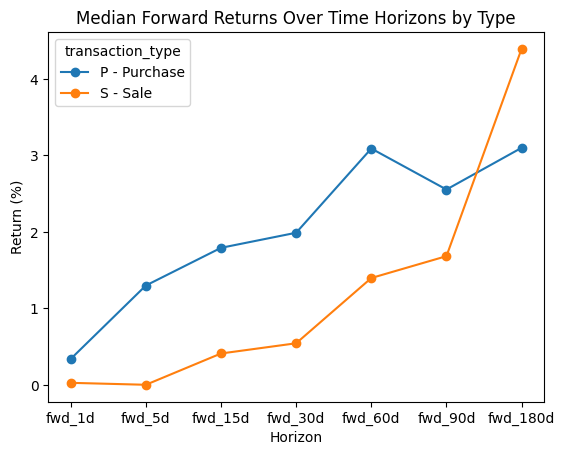

In [114]:
import matplotlib.pyplot as plt

# Group by type and compute mean forward returns
avg_returns = df.groupby('transaction_type')[fwd_cols].mean()

print("Average Forward Returns by Transaction Type:")
print(avg_returns)

# Line plot of average returns over horizons
avg_returns.T.plot(kind='line', marker='o')
plt.title('Average Forward Returns Over Time Horizons by Type')
plt.ylabel('Return (%)')
plt.xlabel('Horizon')
plt.show()

median_returns = df.groupby('transaction_type')[fwd_cols].median()

print("Median Forward Returns by Transaction Type:")
print(median_returns)

# Line plot of median returns over horizons
median_returns.T.plot(kind='line', marker='o')
plt.title('Median Forward Returns Over Time Horizons by Type')
plt.ylabel('Return (%)')
plt.xlabel('Horizon')
plt.show()

In [123]:
# By Insider Title
# Do CEO trades perform better?
title_counts = df['Title'].value_counts()
print(f"Number of unique titles: {len(title_counts)}")
# print(title_counts.head(30))  # Top 30 most common

# Priority list: Higher roles come first
priority_roles = [
    'ceo', 'chief executive officer', 'dir', 'director','cto', 'chief technology officer', 'cfo', 
    'chief financial officer', 'coo', 'chief operating officer', 'pres','president', 'vp', 'vice president', 'svp', 'evp',
    '10%', 'chairman', 'other'
]

# Function to map title with precedence
def map_title_with_precedence(title):
    if pd.isna(title):
        return 'unknown'
    title = title.lower().strip()
    
    # Check each role in priority order
    for role in priority_roles:
        if role == 'other':
            return 'other'  # Default if no match
        elif role == 'vp':  # Handle vp variations
            if 'senior' in title and 'vp' in title or 'vice president' in title or 'svp' in title:
                return 'svp'
            elif 'executive' in title and 'vp' in title or 'vice president' in title or 'evp' in title:
                return 'evp'
            elif 'vp' in title or 'vice president' in title:
                return 'vp'
        elif role in title:
            return role
        elif 'chief' in title or 'c-' in title or 'exec' in title:
            if 'technology' in title:
                return 'cto'
            elif 'financial' in title:
                return 'cfo'
            elif 'operating' in title:
                return 'coo'
            else:
                return 'C-suite exec'
        elif 'chair' in title or 'board' in title or 'trustee' in title or 'cob' in title:
            return 'chairman'
    return 'other'


df['Title_grouped'] = df['Title_clean'].apply(map_title_with_precedence)
print(f"\n\nUnique grouped titles: {df['Title_grouped'].nunique()}")
print(df['Title_grouped'].value_counts())

# ret = []
# for title in df['Title'].dropna().unique():
#     r = map_title_with_precedence(title)
#     if r == 'other':
#         ret.append(title)
# # print(ret)
# print(pd.Series(ret).value_counts())

Number of unique titles: 9092


Unique grouped titles: 13
Title_grouped
dir             58807
ceo             31718
10%             23215
C-suite exec    16982
cfo             13635
other           11329
evp             11321
svp              9090
pres             8096
coo              5860
vp               5104
chairman         3475
cto              2746
Name: count, dtype: int64


Average Forward Returns for Buys by Grouped Title:
                 fwd_1d    fwd_5d   fwd_15d   fwd_30d   fwd_60d   fwd_90d  fwd_180d
Title_grouped                                                                      
vp             0.206275  0.464730  1.056808  0.977197  1.801888  3.352846  7.128835
chairman       0.083939  0.084624  0.692408  1.246977  3.370076  3.348206  6.004974
svp            0.083678  0.000000  0.594054  0.694143  1.793828  2.584214  5.489943
evp            0.083745  0.025102  0.495749  0.738060  2.081421  2.451865  5.189539
pres           0.042540  0.027389  0.364403  0.837318  1.543916  2.024309  4.878610
ceo            0.040159  0.000000  0.354316  0.400434  1.160563  1.669945  4.267197
dir            0.000000 -0.067159  0.385920  0.601050  1.497619  1.590290  4.410481
C-suite exec   0.039999 -0.034653  0.503941  0.695844  1.479820  1.564449  4.316619
cto            0.000000  0.202820  0.758459  0.976478  1.673948  1.554032  4.869201
cfo            0.024229  

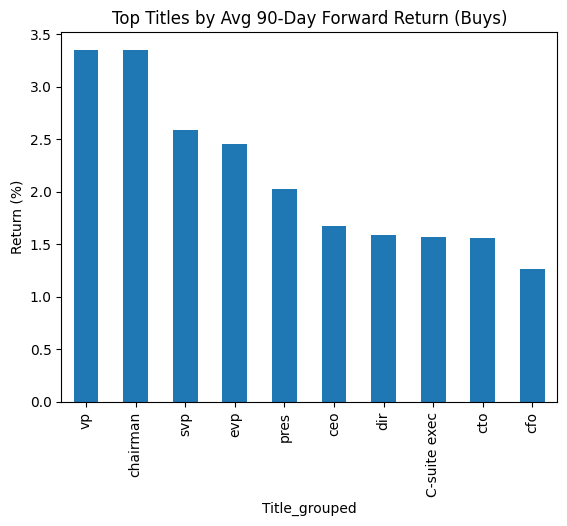

In [124]:
# avg_by_title = df[df['transaction_type'] == 'P - Purchase'].groupby('Title_grouped')[fwd_cols].median().sort_values('fwd_90d', ascending=False)
avg_by_title = df[df['transaction_type'] == 'S - Sale'].groupby('Title_grouped')[fwd_cols].median().sort_values('fwd_90d', ascending=False)
print("Average Forward Returns for Buys by Grouped Title:")
print(avg_by_title)

# Visualize top 10
import seaborn as sns
import matplotlib.pyplot as plt

top_titles = avg_by_title.head(10)
top_titles['fwd_90d'].plot(kind='bar')
plt.title('Top Titles by Avg 90-Day Forward Return (Buys)')
plt.ylabel('Return (%)')
plt.show()

In [ ]:
# By Trade Size (e.g., Value Quartiles)
# Larger trades might be stronger signals.
df['value_quartile'] = pd.qcut(df['Value'], q=4, labels=['Small', 'Medium', 'Large', 'X-Large'])
avg_by_size = df.groupby(['transaction_type', 'value_quartile'])[fwd_cols].mean()
print("Average Forward Returns by Trade Size:")
print(avg_by_size)

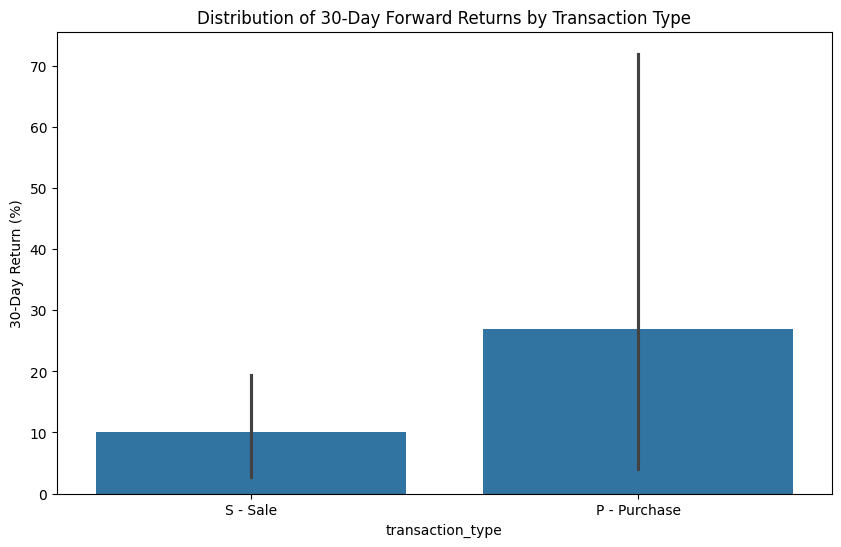

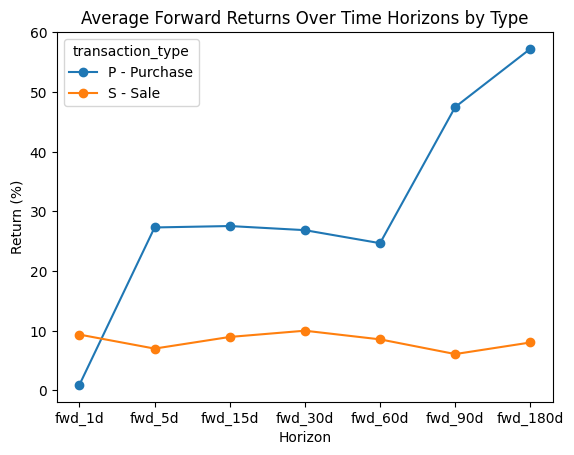

In [99]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot of 30-day forward returns by type
plt.figure(figsize=(10, 6))
sns.barplot(x='transaction_type', y='fwd_30d', data=df)
plt.title('Distribution of 30-Day Forward Returns by Transaction Type')
plt.ylabel('30-Day Return (%)')
plt.show()

# Line plot of average returns over horizons
avg_returns.T.plot(kind='line', marker='o')
plt.title('Average Forward Returns Over Time Horizons by Type')
plt.ylabel('Return (%)')
plt.xlabel('Horizon')
plt.show()

In [ ]:
import glob
import pandas as pd
import os

for filepath in glob.glob("ticker_data/*.csv"):
    df = pd.read_csv(filepath, nrows=10)
    if df.empty or len(df) <= 5:
        print(f"File {filepath} is empty or too short, deleting it.")
        os.remove(filepath)
        continue

In [ ]:
def get_ticker_price_history(ticker):
    prices = pd.read_csv(f"ticker_data/{ticker}.csv", skiprows=3, 
                             names=["Date", "Close", "High", "Low", "Open", "Volume"], parse_dates=["Date"], index_col="Date")
    for col in ["Close", "High", "Low", "Open", "Volume"]:
        prices[col] = pd.to_numeric(prices[col], errors="coerce")
    return prices

Found 83 insider trades for ICUI
                    filing_date                    Title transaction_type purchase_price        Value   fwd_30d
trade_date                                                                                                     
2015-04-06  2015-04-08 17:19:59                      Dir         S - Sale         $93.50    -$175,307 -8.359818
2015-06-11  2015-06-11 16:43:39                 Dir, 10%         S - Sale         $96.11  -$1,595,590 -8.359818
2015-06-09  2015-06-09 19:12:08                 Dir, 10%         S - Sale         $94.83  -$1,175,855 -8.359818
2015-06-05  2015-06-05 18:00:50                 Dir, 10%         S - Sale         $95.97  -$1,026,922 -8.359818
2015-06-02  2015-06-02 17:59:19                 Dir, 10%         S - Sale         $97.51  -$1,170,066 -8.359818
...                         ...                      ...              ...            ...          ...       ...
2024-12-06  2024-12-06 16:43:13  VP, GM-Infusion Capital         S - Sa

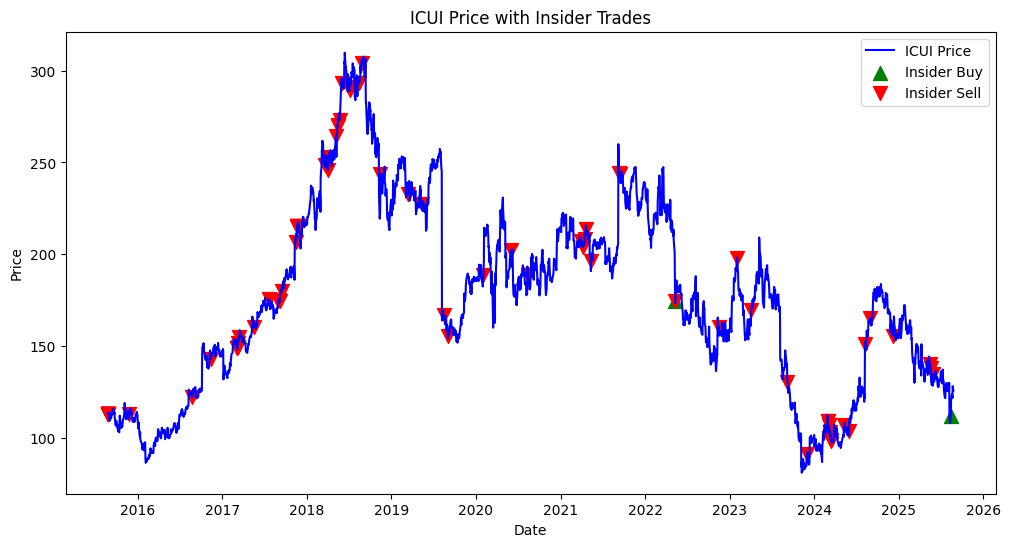

In [137]:
import pandas as pd
import matplotlib.pyplot as plt
import sys


insiders = pd.read_csv("insider_trades_with_returns.csv", parse_dates=["trade_date"], index_col="trade_date")
pd.set_option('display.width', 1000)

ticker = "ICUI"
prices = get_ticker_price_history(ticker)
prices = prices.sort_index(ascending=True)

if prices.empty:
    print(f"No price data found for {ticker}")
    sys.exit(1)

insider_trades = insiders[insiders["ticker"] == ticker]
print(f"Found {len(insider_trades)} insider trades for {ticker}")
print(insider_trades[["filing_date", "Title", "transaction_type", "purchase_price", "Value", 'fwd_30d']])

# If trade_date is not a trading day, move forward to next available trading day
for trade_date in insider_trades.index:
    if trade_date not in prices.index:
        pos = prices.index.searchsorted(trade_date)
        print(f"Trade date {trade_date.date()} not in price data, moving to next trading day {prices.index[pos].date()}")
        insider_trades = insider_trades.rename(index={trade_date: prices.index[pos]})

# Plot price history
plt.figure(figsize=(12,6))
plt.plot(prices.index, prices["Close"], label=f"{ticker} Price", color="blue")

# Plot insider purchases and sales
buys = insider_trades[insider_trades["transaction_type"]=="P - Purchase"]
sells = insider_trades[insider_trades["transaction_type"]=="S - Sale"]

plt.scatter(buys.index, 
            prices.loc[buys.index, "Close"], 
            color="green", marker="^", s=100, label="Insider Buy")

plt.scatter(sells.index, 
            prices.loc[sells.index, "Close"], 
            color="red", marker="v", s=100, label="Insider Sell")

plt.title(f"{ticker} Price with Insider Trades")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


In [ ]:
clusters = insiders.groupby(["ticker", "trade_date"]).size().reset_index(name="num_trades")
clusters = clusters[clusters["num_trades"] > 5].sort_values(by=["num_trades"], ascending=False)  # multiple insiders same day
print(clusters.head(20))

In [ ]:
print("\nClusters of multiple insiders trading the same week:")
insiders["trade_date"] = pd.to_datetime(insiders.index)
insiders["week"] = insiders["trade_date"].dt.to_period("W").apply(lambda r: r.start_time)
weekly_clusters = (
    insiders.groupby(["ticker", "week", "transaction_type"])
    .size()
    .reset_index(name="num_trades")
)

clusters = weekly_clusters[weekly_clusters["num_trades"] > 10]
print(clusters.sort_values(["num_trades"], ascending=False).head(10))


Outliers for Buys (IQR Method):
      ticker  trade_date                      company_name                            owner_name Title_grouped transaction_type         fwd_1d   horizon  fwd_5d  fwd_15d  fwd_30d  fwd_60d  fwd_90d    fwd_180d
0         OV  2017-03-30    Overseas Shipholding Group Inc  Bluemountain Capital Management, LLC           10%         S - Sale  306328.572869    fwd_1d     NaN      NaN      NaN      NaN      NaN         NaN
1         OV  2017-03-14    Overseas Shipholding Group Inc  Bluemountain Capital Management, LLC           10%         S - Sale  299899.990740    fwd_1d     NaN      NaN      NaN      NaN      NaN         NaN
2         OV  2017-03-16    Overseas Shipholding Group Inc  Bluemountain Capital Management, LLC           10%         S - Sale  293471.408611    fwd_1d     NaN      NaN      NaN      NaN      NaN         NaN
3         OV  2017-04-04    Overseas Shipholding Group Inc  Bluemountain Capital Management, LLC           10%         S - Sale  282

C:\Users\Wescules\AppData\Local\Temp\ipykernel_45320\137972801.py:57: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(fwd_cols, rotation=45)
C:\Users\Wescules\AppData\Local\Temp\ipykernel_45320\137972801.py:63: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(fwd_cols, rotation=45)


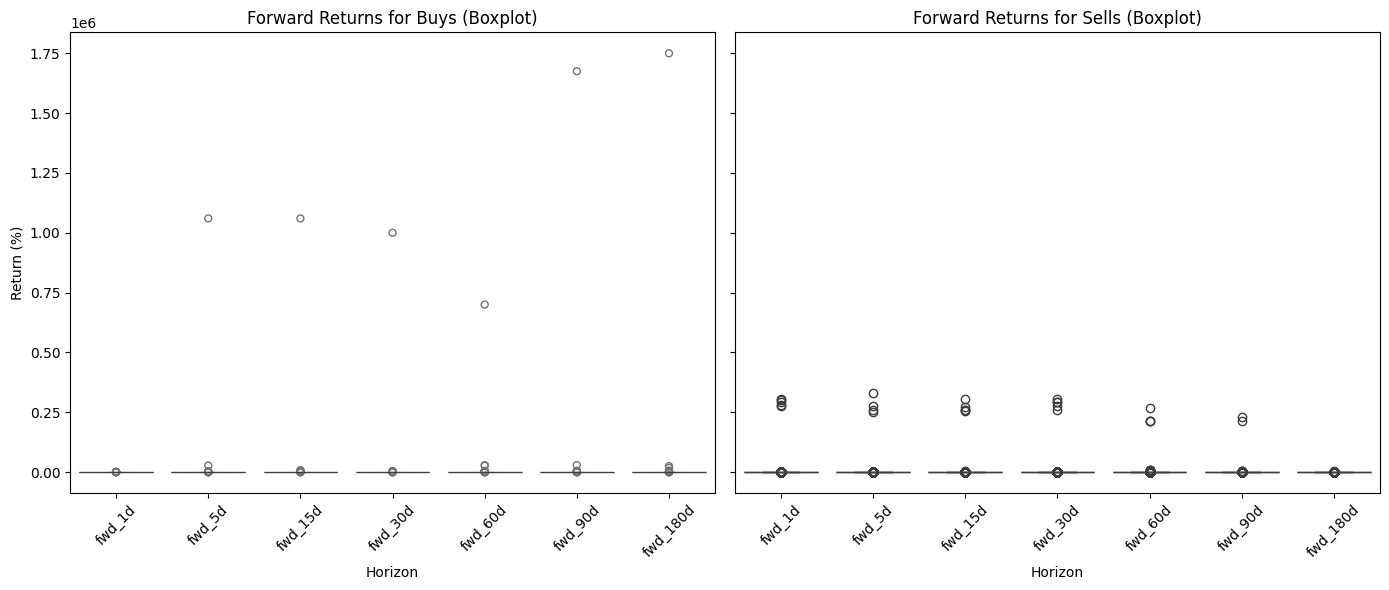

In [134]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Assuming fwd_cols and DataFrame df are defined
fwd_cols = ['fwd_1d', 'fwd_5d', 'fwd_15d', 'fwd_30d', 'fwd_60d', 'fwd_90d', 'fwd_180d']

# Function to identify outliers using IQR
def find_iqr_outliers(df, column, transaction_type=None):
    if transaction_type:
        df_subset = df[df['transaction_type'] == transaction_type][column]
    else:
        df_subset = df[column]
    
    Q1 = df_subset.quantile(0.25)
    Q3 = df_subset.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    outliers = outliers.sort_values(by=column, ascending=False)
    return outliers[['ticker', 'trade_date', 'company_name', 'owner_name', 'Title_grouped', 'transaction_type', column]]

# Find outliers for buys and sells separately
outliers_buys = []
outliers_sells = []
for col in fwd_cols:
    buy_outliers = find_iqr_outliers(df, col, transaction_type='P - Purchase')
    sell_outliers = find_iqr_outliers(df, col, transaction_type='S - Sale')
    if not buy_outliers.empty:
        buy_outliers['horizon'] = col
        outliers_buys.append(buy_outliers)
    if not sell_outliers.empty:
        sell_outliers['horizon'] = col
        outliers_sells.append(sell_outliers)

# Combine outliers
outliers_buys = pd.concat(outliers_buys, ignore_index=True) if outliers_buys else pd.DataFrame()
outliers_sells = pd.concat(outliers_sells, ignore_index=True) if outliers_sells else pd.DataFrame()

# Print results
print("Outliers for Buys (IQR Method):")
print(outliers_buys)
print("\nOutliers for Sells (IQR Method):")
print(outliers_sells)

# Visualize outliers with boxplots (side by side for buys and sells)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6), sharey=True)

# Boxplot for buys
sns.boxenplot(data=df[df['transaction_type'] == 'P - Purchase'][fwd_cols], ax=ax1)
ax1.set_title('Forward Returns for Buys (Boxplot)')
ax1.set_ylabel('Return (%)')
ax1.set_xlabel('Horizon')
ax1.set_xticklabels(fwd_cols, rotation=45)

# Boxplot for sells
sns.boxplot(data=df[df['transaction_type'] == 'S - Sale'][fwd_cols], ax=ax2)
ax2.set_title('Forward Returns for Sells (Boxplot)')
ax2.set_xlabel('Horizon')
ax2.set_xticklabels(fwd_cols, rotation=45)

plt.tight_layout()
plt.show()